# Introduction
## Link to GitHub repository
## Purpose
In this analysis, I’ll use a raster dataset from the U.S. Geological Survey (USGS) to extract land cover statistics in a small region surrounding Mount Whitney in California. The numbers contained in the raster represent land cover classification, so I will also have to use an accompanying CSV file from USGS that tells us what classes of land cover correspond to these numbers. I’ll also be creating a simple map showing the area of analysis relative to Mount Whitney. An analysis of this kind has potential use for government agencies seeking to better understand land cover in a region.

![Mount Whitney](mount_whitney.jpeg)

## About
At an elevation of 14,505 feet above sea level, Mount Whitney is the tallest mountain in the contiguous United States. Located in the Sierra Nevada mountain range, Mount Whitney's western slope and summit are located in Sequoia National Park, and the summit is also the southern terminus of the popular John Muir trail, which stretches over 200 miles from Yosemite Valley down to Mount Whitney. The eastern slope is part of the Inyo National Forest and is managed by the U.S. Forest Service.

## Highlights of analysis
- Exracting pixels per land cover class from raster dataset
- Marging extracted pixels with tabular dataset matching numeric codes to character strings
- Creating horizontal bar plot showing percent area of different land cover classes
- Extracting bounding box of raster dataset
- Creating map that shows area of land cover analysis relative to Mount Whitney with California boundaries as a basemap

## Data
### USGS land cover raster dataset
The primary dataset that we will be working with comes from the 2011 National Terrestrial Ecosystems data, which was collected as part of the USGS Gap Analysis Project (GAP) by the U.S. Forest Service and Department of the Interior (2). For the purposes of this analysis, the full, nationwide dataset was pre-processed in Microsoft Planetary Computer to only include the area around Mount Whitney. With 30 meter by 30 meter pixel resolution, this raster dataset is a TIF file and contains numbers representing land cover classification.

U.S. Geological Survey (USGS) Gap Analysis Project (GAP), 2016, GAP/LANDFIRE National Terrestrial Ecosystems 2011: U.S. Geological Survey data release, https://doi.org/10.5066/F7ZS2TM0.


In [12]:
import os
import xarray as xr
import rioxarray as rioxr

# Import land cover TIF as xarray.DataArray
lulc_fp = os.path.join(os.getcwd(),'..','data','2023-12-11-post-data','land_cover.tif')
lulc = rioxr.open_rasterio(lulc_fp)

### USGS land cover tabular dataset
Our second dataset is also from the 2011 National Terrestrial Ecosystems data and helps us make sense of data in the raster dataset. This tabular dataset is a CSV file and has the land cover classification names associated with each code used in the raster dataset. This dataset was accessed from the same online source as the raster dataset.

In [13]:
import pandas as pd

# Import accompanying CSV as pandas.DataFrame
class_names = pd.read_csv('../data/2023-12-11-post-data/GAP_National_Terrestrial_Ecosystems.csv')

### Shapefile of California geographic boundaries
The final dataset that we will be using is a shapefile of California geographic boundaries, included in the U.S. Census Bureau's 2016 Topologically Integrated Geographic Encoding and Referencing (TIGER) database. We will use this shapefile to plot our basemap when visualizing our area of analysis.

Citation

In [4]:
import pandas as pd
import geopandas as gpd

# Import CA shapefile as geopandas.GeoDataFrame
ca = gpd.read_file('https://data.ca.gov/dataset/e212e397-1277-4df3-8c22-40721b095f33/resource/3db1e426-fb51-44f5-82d5-a54d7c6e188b/download/ca-state-boundary.zip')

## Import libraries and functions
We'll start by importing all our necessary libraries and functions for our analysis. Some of these packages we already imported before reading in our data, but we will again include them here just to remind us of all the packages that we are using.

In [8]:
# General libraries and functions
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Geospatial libraries and functions
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box
from shapely.geometry import Point

## Raster reduction
Next, we reduce the size of the raster, which is stored in our Python environment as a *xarray.DataArray* named `lulc`. We want to remove these unnecessary raster componenets to simplify our Python environment, often helping our code run faster as well.

In [14]:
# Remove band dimension
lulc = lulc.squeeze()

# Remove coordinates associated to band
lulc = lulc.drop('band')

# Part 1: Calculating and plotting percent area of land cover classes
## Calculate percent area of land cover classes
Now that we are working with a reduced raster, we can move on to calculating percent area of the different land cover classes. To do this, we must extract the unique values contained in the `lulc` *xarray.DataArray*, in addition to the count of how many times each unique value appears in our raster. Since these codes correspond to land cover classes specified in our `class_names` *pandas.DataFrame*, we need to merge the extracted codes and counts with `class_names`, which requires storing our codes and counts as a *pandas.DataFrame*. Once we have this merged *pandas.DataFrame*, which we stored as `classes`, performing the actual calculation can be easily accomplished. We just use the count column in `classes` and size of `lulc` as object attributes.

In [15]:
# Extract pixels per land cover class
codes, counts = np.unique(lulc, return_counts = True)

# Create extracted pixels DataFrame
pix_counts = pd.DataFrame({'code': codes, 'count': counts})

# Merge extracted pixels DataFrame with class names DataFrame
classes = pd.merge(pix_counts, class_names, on='code', how='inner')

# Calculate the percentage of area covered by each class
classes['percentage'] = (classes['count'] / lulc.size) * 100

## Create horizontal bar plot
Next, we will our percent values with a horizontal bar plot, which shows us the percent for each land cover classification that takes up at least 1% of the area. We filter for just these land cover classes to reduce the amount of output, as it is likely irrelevant for an audience to see the percent for land cover classes that only take up a very small area. We also use the `sort_values` function, so we can plot our horizontal bars in ascending order, making our plot easier to interpret.

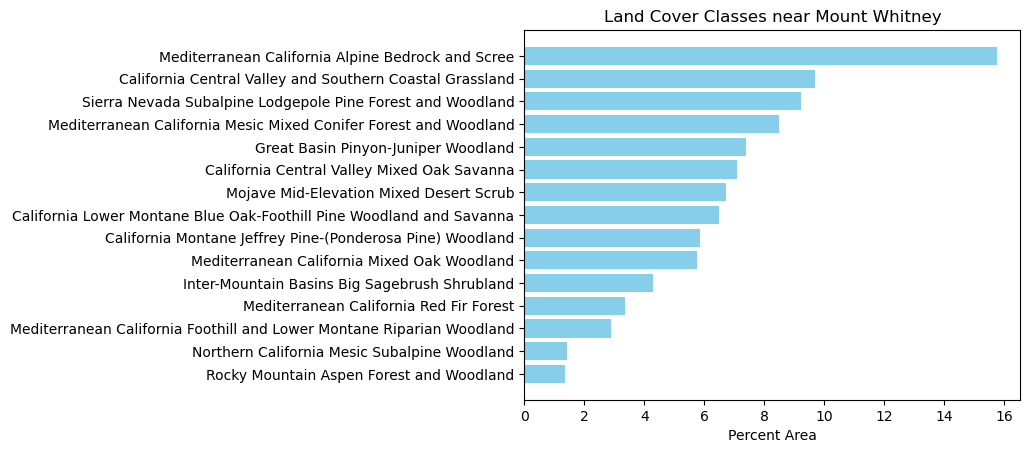

In [16]:
# Filter for classes with more than 1% land cover
filtered_classes = classes[classes['percentage'] > 1]

# Sort classes in decreasing order of percentage
sorted_classes = filtered_classes.sort_values(by='percentage', ascending=True)

# Create a horizontal bar plot with axis label and title
plt.barh(sorted_classes['class_label'], sorted_classes['percentage'], color='skyblue')
plt.xlabel('Percent Area')
plt.title('Land Cover Classes near Mount Whitney')

# Show plot
plt.show()

# Part 2: Plotting map showing area of land cover analysis relative to Mount Whitney
## Create GeoDataFrames for area of analysis and Mount Whitney
To better understand our area of analysis relative to Mount Whitney, we want to plot the geographic coordinates of `lulc` and a point for Mount Whitney on the same map. To do this, we first extract the bounding box of `lulc`, which gives us four coordinate points that make up a rectangle denoting the area analyzed from our raster. In this case, we know that our raster area was a square, which means that extracting the bounding box does not include additional area that was not part of the analysis. Next, we convert these points into a *shapely.Polygon*, which then allows us to create a *geopandas.GeoDataFrame* containing this polygon. Lastley, we make another *geopandas.GeoDataFrame* that just contains a single point for Mount Whitney. We know to provide the coordinates for Mount Whitney in the EPSG:4326 Coordinate Reference System because this is the same CRS that is set for the USGS data that we read in as `lulc`.

In [17]:
# Extract bounding box of LULC tile
bbox_coords = lulc.rio.bounds()

# Create shapely polygon from bounding box coordinates
bbox_polygon = box(bbox_coords[0], bbox_coords[1], bbox_coords[2], bbox_coords[3])

# Create GeoDataFrame for bounding box of LULC tile
bbox = gpd.GeoDataFrame(geometry=[bbox_polygon], crs=lulc.rio.crs)

# Create GeoDataFrame with a single point for Mount Whitney
mt_whitney = gpd.GeoDataFrame(geometry=[Point(-118.2929, 36.5786)], crs='EPSG:4326')

## Plot map showing area of land cover analysis relative to Mount Whitney
After changing the CRS of `bbox` and `ca` to also match `lulc`, we can finally create our map showing the area of analysis relative to Mount Whitney!

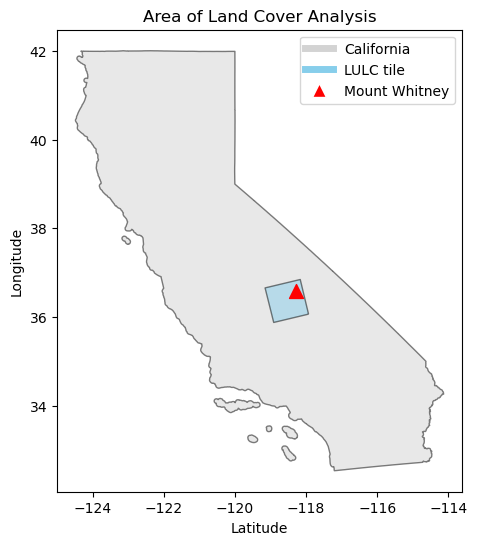

In [18]:
# Change CRS of LULC tile bounding box to EPSG:4326
bbox.to_crs('EPSG:4326', inplace=True)

# Change CRS of CA boundaries to EPSG:4326
ca.to_crs('EPSG:4326', inplace = True)

# Initialize figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot CA basemap, LULC tile bounding box, and Mount Whitney point
ca.plot(ax=ax, color='lightgray', edgecolor='black', alpha=0.5, label='California, US')
bbox.plot(ax=ax, color='skyblue', edgecolor='black', alpha=0.5, label='LULC tile')
mt_whitney.plot(ax=ax, marker='^', color='red', markersize=100, label='Mount Whitney')

# Specify legend elements
legend_elements = [plt.Line2D([0], [0], color='lightgray', lw=5, label='California'),
                   plt.Line2D([0], [0], color='skyblue', lw=5, label='LULC tile'),
                   mlines.Line2D([0], [0], marker='^', color='w', markerfacecolor='red', markersize=10, label='Mount Whitney', linestyle='None')]

# Add legend, title, and labels
ax.legend(handles=legend_elements, loc='upper right')
plt.title('Area of Land Cover Analysis')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Show plot
plt.show()